In [1]:
import xml.etree.ElementTree
from os import listdir
from os.path import join
import functools
import random
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt

WORK_DIR = "../Data/bioc-FH-training/"
PROCESSED_DIR = "../Data/processed/"
OBJECTS_DIR = '../objects/'
SUB2_DATA_DIR = "../Data/subtask2/"

In [2]:
# get all data file names
file_list  = listdir(WORK_DIR)
file_names = set()

for file in file_list:
    if file != '' and file.endswith('txt'):
        file_names.add(file.split('.')[0])

assert(len(file_names) == 99)

In [3]:
with open(join(OBJECTS_DIR, 'train_texts.pkl'), 'rb') as text_f:
    texts = pkl.load(text_f)

with open(join(OBJECTS_DIR, 'train_corpus.pkl'), 'rb') as pkl_f:
    corpus = pkl.load(pkl_f)
    
text_files = list(corpus.keys())
train_size = 72
valid_files = text_files[train_size:]

In [4]:
# get corrected entities with format
# (start_posi, end_posi, type, content, id_in_xml)
with open(join(OBJECTS_DIR, 'entities_corrected.pkl'), 'rb') as f:
    entities = pkl.load(f)
print(entities['doc_97'][:5])

[(329, 349, 'FamilyMember', 'Maternal grandfather', {'SideOfFamily': 'Maternal'}, '33'), (368, 375, 'LivingStatus', 'healthy', {'Alive': 'Yes', 'Healthy': 'Yes', 'ID': None}, '12'), (378, 398, 'FamilyMember', 'Maternal grandmother', {'SideOfFamily': 'Maternal'}, '35'), (435, 441, 'FamilyMember', 'Mother', {'SideOfFamily': 'NA'}, '14'), (458, 474, 'Observation', 'severe nosebleed', {'Negation': 'No'}, '15')]


In [5]:
with open(join(OBJECTS_DIR, 'train_sents.pkl'), 'rb') as f:
    sents = pkl.load(f)

# Get relation chains from annotated xml files

In [6]:
def get_entity(entities, id):
    for entity in entities:
        if entity[-1] == id:
            return entity
    return None

In [7]:
entity_pairs = {}
negative_pairs = {}

for file_name in file_names:
    file_path = WORK_DIR + file_name + '.xml'
    root = xml.etree.ElementTree.parse(file_path).getroot()
    annotations = root.findall('annotations')[0]

    # Get all `relation` annotation
    for relation in annotations.findall('relation'):
        properties = relation.find('properties')
        fm_id = properties.find('FamilyMembers').text
        
        if not fm_id: # FamilyMembers is empty
            continue
        else:
            fm = get_entity(entities[file_name], fm_id)
            SoF = fm[4]['SideOfFamily']
        
        for entity in entities[file_name]:
            have_relation = False
            for property_ in properties.findall('Properties'):
                if entity[-1] == property_.text:
                    have_relation = True
                    break

            if have_relation:
                relation_type = ''
                if entity[2] == 'Observation':
                    if entity[4]['Negation'] == 'Yes':
                        relation_type = 'FM_OBS_N'
                    else:
                        relation_type = 'FM_OBS'
                elif entity[2] == 'LivingStatus':
                    relation_type = 'FM_LS'

                if relation_type:
                    entity_pair = (fm[0], fm[1], entity[0], entity[1],
                                   {"SoF": SoF}, relation_type)
                    entity_pairs[file_name] = entity_pairs.get(file_name, []) + [entity_pair]
            elif entity[2] == 'Observation' and fm[1] < entity[1]:
                negative_pair = (fm[0], fm[1], entity[0], entity[1], {"SoF": SoF}, 'OTHERS')
                negative_pairs[file_name] = negative_pairs.get(file_name, []) + [negative_pair]
print(entity_pairs['doc_97'])

[(1013, 1018, 1038, 1045, {'SoF': 'Paternal'}, 'FM_LS'), (1063, 1069, 1081, 1088, {'SoF': 'Paternal'}, 'FM_LS'), (435, 441, 458, 474, {'SoF': 'NA'}, 'FM_OBS'), (435, 441, 479, 490, {'SoF': 'NA'}, 'FM_OBS'), (435, 441, 542, 549, {'SoF': 'NA'}, 'FM_LS'), (908, 914, 935, 951, {'SoF': 'NA'}, 'FM_OBS'), (1091, 1099, 1121, 1129, {'SoF': 'NA'}, 'FM_OBS'), (1091, 1099, 1138, 1159, {'SoF': 'NA'}, 'FM_OBS'), (1091, 1099, 1184, 1205, {'SoF': 'NA'}, 'FM_OBS'), (329, 349, 368, 375, {'SoF': 'Maternal'}, 'FM_LS'), (552, 565, 585, 592, {'SoF': 'NA'}, 'FM_LS'), (595, 610, 622, 636, {'SoF': 'NA'}, 'FM_OBS'), (595, 610, 641, 655, {'SoF': 'NA'}, 'FM_OBS'), (595, 610, 666, 673, {'SoF': 'NA'}, 'FM_LS'), (680, 702, 717, 724, {'SoF': 'Maternal'}, 'FM_LS'), (726, 746, 766, 781, {'SoF': 'Paternal'}, 'FM_OBS'), (812, 832, 857, 888, {'SoF': 'Paternal'}, 'FM_OBS'), (812, 832, 897, 905, {'SoF': 'Paternal'}, 'FM_OBS')]


# Generating positive training data
Concate the two sentences where FM and OBS are in

In [8]:
def get_sent(sents, span_end):
    span = 0
    for sent_id, sent in enumerate(sents):
        span += len(sent) + 2 # 2 for default 2 white spaces between sents
        if span >= span_end:
            return sent_id, sent
    return None, None

In [9]:
def entity_pairs2data(doc, ent_pairs):
    """ from entity pairs to training data """
    num_single_sent, diff = 0, []
    instances = []
    
    for entity in ent_pairs:
        ent1_start, ent1_end, ent2_start, ent2_end, attributes, label = entity
        ent1 = texts[doc][ent1_start:ent1_end]
        ent2 = texts[doc][ent2_start:ent2_end]

        sent1_id, sent1 = get_sent(sents[doc], ent1_end)
        sent2_id, sent2 = get_sent(sents[doc], ent2_end)
        
        if attributes['SoF'] == 'Maternal':
            fm_replace = "@MatenalRelative$"
        elif attributes['SoF'] == 'Paternal':
            fm_replace = "@PatenalRelative$"
        else:
            fm_replace = "@Relative$"

        if label == 'FM_LS':
            sec_replace = "@Status$"
        else:
            sec_replace = "@Disease$"

        
        if sent1 and sent2:
            type(sent1_id)
            type(sent2_id)
            if sent1_id != sent2_id:
                sent1 = sent1.replace(ent1, fm_replace)
                sent2 = sent2.replace(ent2, sec_replace)
                if sent1_id > sent2_id:
                    print("swapped:", sent1, sent2)
                    sent1_id, sent2_id = sent2_id, sent1_id
                    sent1, sent2 = sent2, sent1

                if sent2_id - sent1_id > 1:
                    train_sent = ' '.join([sent1] + sents[doc][sent1_id + 1:sent2_id] + [sent2])
#                 elif sent2_id - sent1_id >= 5:
#                     train_sent = ' '.join([sent1] + sents[doc][sent1_id + 1] \
#                                     + sents[doc][sent2_id - 1] + [sent2])
                else:
                    train_sent = ' '.join([sent1, sent2])

                # instance: ([doc, sent_ids], sent1_to_sent2, label)
                instances.append(('_'.join([doc, str(sent1_id), str(sent2_id)]),
                                  train_sent,
                                  label,
                                  ent1,
                                  ent2,
                                  sent2_id - sent1_id,
                                 ))
                diff.append(sent2_id - sent1_id)
            else:
                sent1 = sent1.replace(ent1, fm_replace).replace(ent2, sec_replace)

                num_single_sent += 1
                instances.append(('_'.join([doc, str(sent1_id)]),
                                  sent1,
                                  label,
                                  ent1,
                                  ent2,
                                  sent2_id - sent1_id
                                 ))
        else:
            print('*'*10)

    return num_single_sent, diff, instances

In [ ]:
positive_data = {}
diffs, single_sent = [], 0
num_ent_pairs = 0


for doc, ent_pairs in entity_pairs.items():
#     print(texts[doc])
    new_single_sent, diff, posi_instances = entity_pairs2data(doc, ent_pairs)
    num_ent_pairs += len(ent_pairs)

    if diff:
        diffs += diff
    single_sent += new_single_sent

    positive_data[doc] = positive_data.get(doc, []) + posi_instances

positive_data['doc_97']

In single sent: 864 , across sents: 316


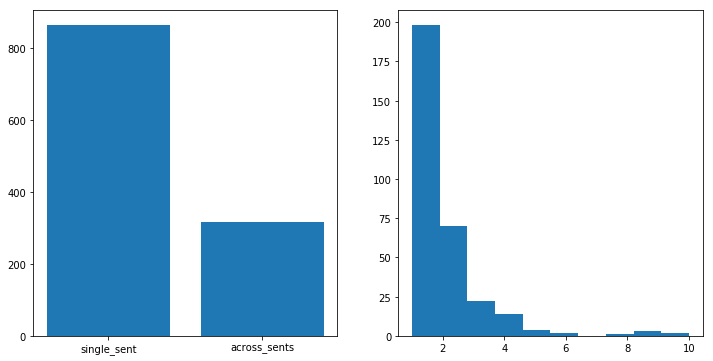

Counter({1: 198, 2: 70, 3: 22, 4: 14, 5: 4, 9: 3, 10: 2, 6: 2, 8: 1})


In [11]:
from collections import Counter
print("In single sent:", single_sent, ", across sents:", len(diffs))
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

names = ['single_sent', 'across_sents']
values = [single_sent, len(diffs)]
axs[0].bar(names, values)

axs[1].hist(diffs)

plt.show()
print(Counter(diffs))

# Generating negative training data

In [12]:
neg_candidates = sum(map(len, negative_pairs.values()))
print("Number of negative data candidates:", neg_candidates)
len_posi = single_sent + len(diffs)
negative_data = {}

neg_single_sent, neg_diffs = 0, []

for doc, ent_pairs in negative_pairs.items():
    num_to_gen = round(len(ent_pairs) / neg_candidates * len_posi)
    _, _, nega_instances = entity_pairs2data(doc, ent_pairs)
    
    samples = []
    for sample in nega_instances:
        # larger the sentence distance, smaller the prob been selected
        if sample[-1] == 0:
            samples.append(sample)
            neg_single_sent += 1
        elif np.random.rand() < 0.65 ** sample[-1]:
            samples.append(sample)
            
            neg_diffs.append(sample[-1])

    negative_data[doc] = samples

Number of negative data candidates: 3872


For negative data:
In single sent: 37 , across sents: 638


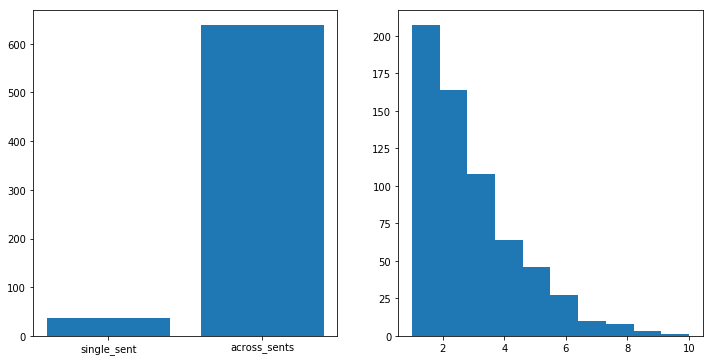

In [13]:
print("For negative data:\nIn single sent:", neg_single_sent, ", across sents:", len(neg_diffs))
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

names = ['single_sent', 'across_sents']
values = [neg_single_sent, len(neg_diffs)]
axs[0].bar(names, values)

axs[1].hist(neg_diffs)

plt.show()

In [ ]:
negative_data

# shuffling and split data

In [15]:
data = []
for doc, posi in positive_data.items():
    try:
        data += posi + negative_data[doc]
    except KeyError:
        pass
random.shuffle(data)

In [16]:
amount = len(data)
train_ratio = 0.8
validation = 1 - train_ratio

data = {'train': data[:int(train_ratio*amount)], 'valid': data[int(train_ratio*amount):]}
with open(join("../Data", 're_data.pkl'), 'wb') as f:
    pkl.dump(data, f)

In [17]:
def write_data(data, file):
    f = open(join("../Data", file), 'w')
    
    for item in data:
        # content: [id, sent1, label, fm, obs,diff]
        content = [item[0], item[1], item[2], item[3], item[4]]
        f.write('\t'.join(content) + '\n')
        
    f.close()

write_data(data['train'], 're_train_data.txt')
write_data(data['valid'], 're_valid_data.txt')